<h4>Import required libraries</h4>

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numba import jit
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

In [2]:
# Ensures Proper Plots
stylesheet = {'axes.titlesize': 20,
              'axes.linewidth': 1.2,
              'axes.labelsize': 18,
              'font.size': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 14,
              'xtick.major.size': 5,
              'xtick.major.width': 1.2,
              'ytick.labelsize': 14,
              'ytick.major.size': 5,
              'ytick.major.width': 1.2,
              'figure.autolayout': True}
plt.rcParams.update(stylesheet)

<h3>Constants and Global parameters</h3>

Within the code we use natural units. This allows us to ignore many parameters since they are 1. More importantly it allows for the expression of physical quantities in terms of these units, making the simulation representative of all gases with similar interaction.

In [3]:
# Physical parameters in natural units

#These variables are always equal to one, as such they do not need to be declared.
#mass = 1                                   # Mass of an Argon atom
#sigma = 1                                  # Position of the minimum of potential well
#epsilon = 1                                # Depth of potential well.
#kb = 1                                     # Boltzmann constant
#tau = ((mass/epsilon) * sigma**2) ** (1/2) # Unit of time

In [4]:
#These parameters will always be taken the same value
dt = 4e-3           # Size of a time step 4e-3*tau ~ 1e-14 s
r_cut = 3     # Cut-off distance
noCutoff = False    # Turn off cutoff distance

<h1>Essential Functions</h1>

<h3>Initialization</h3>

Defines the function that initializes the position of the particles and their momenta.
The particles are placed in a fcc lattice and are given momenta that are picked from a maxwell-boltzmann distribution.

In [5]:
def initializeRP(N,M,T,a):
    
    # Initialize positions, r
    r = np.zeros((N,3))
    unit_cell = np.array([[0.0, 0.0, 0.0],[0.5*a, 0.5*a, 0.0],[0.5*a, 0.0, 0.5*a],[0.0, 0.5*a, 0.5*a]]) # Position of atoms in the unit cell
    
    # Place particles on the lattice
    n = 0                                     # Number of particles placed so far
    for i in range(M):
        for j in range(M):
            for k in range(M):
                for l in range(4):
                    if n<N:
                        r[n,:] = unit_cell[l,:] + [i*a, j*a, k*a]
                        n += 1                # Placed an additional particle
    
    # Initialize momenta of particles, p
    p = np.random.normal(0, (T)**(1/2), (N,3))
    
    # Correct for drift of center of mass
    vCM = np.sum(p,0)/N                       # Velocity of center of mass
    p -= vCM
    
    # Rescale the velocity to agree with the temperature
    p = p * (((N-1)*3*T)/ (np.sum(p*p)))**(1/2)
    
    return r, p

<h3>Force Calculation</h3>

Defines the function that is used to calculate the force each particle feels due to the two-particle interactions. The interactions are governed by a Lennard-Jones potential.
Additionally the potential energy of the gas is calculated and one of the coeffients needed to calculate the pressure are determined.

In [6]:
@jit
def computeForce(r,N,L_box,compPressure=False):
    force = np.zeros((N,3))
    r_cutsqrd = r_cut*r_cut
    potential = 0
    virialCoeff = 0
    for i in range(N-1):
        for j in range((i+1),N):
            
            rij_x = r[i,0]-r[j,0]
            rij_y = r[i,1]-r[j,1]
            rij_z = r[i,2]-r[j,2]
            
            rij_x -= np.rint(rij_x/L_box)*L_box
            rij_y -= np.rint(rij_y/L_box)*L_box
            rij_z -= np.rint(rij_z/L_box)*L_box
            
            r_sqrd = rij_x*rij_x + rij_y*rij_y + rij_z*rij_z
            
            if (r_sqrd < r_cutsqrd or noCutoff):
                F = 12*((1/r_sqrd)**7 -(1/r_sqrd)**4)
                potential += (1/r_sqrd)**6 -2*(1/r_sqrd)**3
                
                force[i,0] += rij_x*F
                force[j,0] -= rij_x*F
                
                force[i,1] += rij_y*F
                force[j,1] -= rij_y*F
                
                force[i,2] += rij_z*F
                force[j,2] -= rij_z*F
                
                if compPressure:
                    virialCoeff += -r_sqrd * F
                    
    if compPressure:
        return force, potential, virialCoeff
                    
                
    return force, potential

<h3>Simulation</h3>

Defines the function that is used to run a simulation. The function has many optional functionalities to facilitate the computation of several thermodynamic quantities.

In [7]:
def simulate(N,T,a,r_cut,noCutoff,dt,nsteps,neq=500,energyPlot=False,compMomentum=False,constantT=False,compPressure=False,
             returnEnergy=False):
    
    # Number of unit cells
    M = 1                  # Number of unit cell in one direction
    while (4*(M**3)) < N:
        M += 1
    L_box = M*a            # Length of sides of box
    if r_cut > L_box:
        r_cut = 2*L_box/(2**(1/3))

    [r, p] = initializeRP(N,M,T,a) # Intialize the position and momenta of all particles
    r0 = r
    p0 = p
    
    #Initialization of several output variables
    E_kin = np.zeros(nsteps) 
    E_pot = np.zeros(nsteps)
    pressureCoeff = np.zeros(nsteps)
    temperature = np.zeros(nsteps)
    
    force = computeForce(r,N,L_box)[0] #Initialize the force
    
    for i in range(nsteps):
        
        # Verlet applied to position of particle and first part of momentum
        p += 0.5*force*dt
        r += p*dt
        r = r % L_box #Places particles back into box
        
        # Compute new force
        if compPressure:
            force, E_pot[i], pressureCoeff[i] = computeForce(r,N,L_box,compPressure=True)
        else:
            force, E_pot[i] = computeForce(r,N,L_box)
        
        # Second part of momentum, using Verlet
        p += 0.5*force*dt
        
        # For a gas which is kept at a constant temperature or to bring the system into equilibrium
        if ((i%20 == 0 and i<neq) or constantT):
            p = p * (((N-1)*3*T)/ np.sum(p*p))**(1/2)
        
        E_kin[i] = 0.5*np.sum(p*p)
        
    if energyPlot:
        plt.figure()
        plt.plot(np.linspace(0,nsteps,nsteps)*dt,(E_kin+E_pot)/N, label='Total Energy')
        plt.plot(np.linspace(0,nsteps,nsteps)*dt,E_pot/N, label='Potential Energy')
        plt.plot(np.linspace(0,nsteps,nsteps)*dt,E_kin/N, label='Kinetic Energy')
        plt.legend(loc='best')
        plt.xlabel(r'$t (\tau)$')
        plt.ylabel(r'$E (\epsilon)$')
        plt.savefig('.\Figures\Energypp_Time')
        plt.show()
    
    if compMomentum:
        print('Initial momentum:', np.sum(p0,0)/N)
        print('Final momentum:', np.sum(p,0)/N)
        print('Difference in momentum:', np.sum(p0,0)/N-np.sum(p,0)/N )
        
    if compPressure:
        return r, p, pressureCoeff
    
    if returnEnergy:
        E_tot = E_kin + E_pot
        return r, p, E_tot, E_kin
        
    return r, p

<h1>Specific Task Functions</h1>

<h3>Correlation function</h3>

Uses the following formula to determine the correlation function of a set of particles with positions r. <br>
$$ g(r)=\frac{2V}{N(N-1)}\left(\frac{\langle np(r)\rangle }{4\pi r^2 \Delta r}\right) \simeq \frac{\langle np(r) \rangle}{r^2} $$


In [8]:
def Correlation_function(r,nbins):
    rij = np.zeros((N*(N-1))//2)
    count = 0
    
    # Number of unit cells
    M = 1                  # Number of unit cell in one direction
    while (4*(M**3)) < N:
        M += 1
    L_box = M*a            # Length of sides of box
    
    for i in range(N-1):
        for j in range((i+1),N):
                rij_x = r[i,0]-r[j,0]
                rij_x -= np.rint(rij_x/L_box)*L_box
                rij_y = r[i,1]-r[j,1]
                rij_y -= np.rint(rij_y/L_box)*L_box
                rij_z = r[i,2]-r[j,2]
                rij_z -= np.rint(rij_z/L_box)*L_box
                rij[count] = (rij_x*rij_x + rij_y*rij_y + rij_z*rij_z)**(1/2)
                count = count+1
    
    #Order distances in histogram
    Hist = np.histogram(rij, bins=nbins, range=[0, L_box*.5])
    Hist_y = Hist[0]                                                 #height bins
    Hist_x = Hist[1]                                                 #x-values hist
    Delta_x = (Hist_x[1]-Hist_x[0])                                  #bin width
    Center = np.linspace(Delta_x/2, Hist_x[-1]-Delta_x, len(Hist_y)) #Center of bins
    
    
    #Calculate correlation function
    Cor_func = 2*L_box**3*(N*(N-1))**(-1)*Hist_y/(4*math.pi*(Center)**2*Delta_x)
    
    return Cor_func, Center

<h3>Heat capacity</h3>

Determines the canonical heat capacity of the system for a set of temperatures and unit cell sizes using the following formula. <br>

$$ \frac{C_V^{NVT}}{N} = \frac{var \left( E_{pot} \right)}{NT^2} + \frac{3}{2}$$

In [9]:
def Heat_capacity_NVT(N,T_vec,a_vec,r_cut,noCutoff,dt,nsteps,neq):
    
    heat_cap_NVT_vec = np.zeros((len(a_vec),len(T_vec)))  # Initializes the output variable
    std_Cv = np.zeros((len(a_vec),len(T_vec)))            # Initializes the output variable
    
    part_size = 1000                   # The size of one block, for the blocking method

    for i in range(len(a_vec)):
        a = a_vec[i]
        for j in range(len(T_vec)):
            T = T_vec[j]
            
            # Temperature Check
            if T<0.15:                 # Implemented to use extremely large equilibrium times for low temperatures,
                neqspecial = 100000    # can reduce total computation time for a large range of temperatures.
            elif T<0.25:
                neqspecial = 40000
            elif T<0.5:
                neqspecial = 20000
            else:
                neqspecial = 1
                
            if neqspecial>neq:
                equilibrium = neqspecial
                totalsteps = neqspecial + nsteps - neq
            else:
                equilibrium = neq
                totalsteps = nsteps
            
            # Simulation of system
            [E_tot, E_kin] = simulate(N,T,a,r_cut,noCutoff,dt,totalsteps,neq=equilibrium,returnEnergy=True)[2:4]
            E_pot = E_tot - E_kin
            
            # Applies the blocking method
            E_tot_parts = np.reshape(E_tot[equilibrium:],
                                     (part_size,(len(E_tot[equilibrium:])-len(E_tot[equilibrium:])%part_size)/part_size))
            
            mean_sqr_parts = np.mean(E_tot_parts,0)
            var_parts = np.var(E_tot_parts,0)
            
            Cv_parts = var_parts/(N*T**2) + 3/2
            
            heat_cap_NVT_vec[i,j] = np.mean(Cv_parts)
            std_Cv[i,j] = np.std(Cv_parts)
            
            # Acts as a progress bar
            print(j, end = " ")
    return heat_cap_NVT_vec, std_Cv

Determines the microcanonical heat capacity of the system for a set of temperatures and unit cell sizes using the following formula. <br>

 $$ C_V^{NVE} = \left( \frac{2}{3 N} - \frac{var \left( E_{kin} \right)}{ \langle E_{kin}\rangle^2} \right)^{-1} $$

In [10]:
def Heat_capacity_NVE(N,T_vec,a_vec,r_cut,noCutoff,dt,nsteps,neq):
    
    heat_cap_NVE_vec = np.zeros((len(a_vec),len(T_vec)))  # Initializes the output variable
    std_Cv = np.zeros((len(a_vec),len(T_vec)))            # Initializes the output variable
    
    part_size = 1000                   # The size of one block, for the blocking method
    
    for i in range(len(a_vec)):
        a = a_vec[i]
        for j in range(len(T_vec)):
            T = T_vec[j]
            
            # Temperature Check
            if T<0.15:                # Implemented to use extremely large equilibrium times for low temperatures,
                neqspecial = 100000   # can reduce total computation time for a large range of temperatures.
            elif T<0.25:
                neqspecial = 40000
            elif T<0.5:
                neqspecial = 20000
            else:
                neqspecial = 1
                
            if neqspecial>neq:
                equilibrium = neqspecial
                totalsteps = neqspecial + nsteps - neq
            else:                    # Restores the given equilibrium time
                equilibrium = neq
                totalsteps = nsteps
                
            # Simulation of system
            [E_tot, E_kin] = simulate(N,T,a,r_cut,noCutoff,dt,totalsteps,neq=equilibrium,returnEnergy=True)[2:4];
            
            E_kin_parts = np.reshape(E_kin[equilibrium:],
                                     (part_size,(len(E_kin[equilibrium:])-len(E_kin[equilibrium:])%part_size)/part_size))
            
            # Applies the blocking method
            mean_sqr_parts = np.mean(E_kin_parts,0)
            var_parts = np.var(E_kin_parts,0)
            
            Cv_parts = (2/(3*N)-var_parts/(mean_sqr_parts**2))**(-1)/N
            
            heat_cap_NVE_vec[i,j] = np.mean(Cv_parts)
            std_Cv[i,j] = np.std(Cv_parts)
            
            print(j, end = " ")
    return heat_cap_NVE_vec, std_Cv

<h3>Blocking Method</h3>

Split in blocks, find mean of separate blocks. Use these blocks to find standard deviation.

In [11]:
def comp_std_mean(data, correlationtime):
    data_parts = np.reshape(data,(correlationtime,(len(data)-len(data)%correlationtime)/correlationtime))
    parts = np.mean(data_parts,1)
    
    # mean  of data
    mean_data = np.mean(parts)
    
    # standard deviation
    std_data = np.std(parts)
    
    return mean_data, std_data

<h3>Pressure</h3>

Determines the pressure in the system for a set of temperatures and unit cell sizes using the formula given by the virial theorem and using the correction term caused by the cut-off distance. Where we take $g(r)$ approximately 1 for larger distances.<br>
$$ P = \frac{NT}{V} - \frac{1}{3V} \left\langle \sum_i \sum_{j<i} r_{ij} \frac{\partial U_{LJ}}{\partial r_{ij}} \right\rangle_{cutoff} - \left(\frac{N}{V}\right)^2 \frac{2\pi}{3} \int_{r_{cutoff}}^{\infty} r^3 \frac{\partial U_{LJ}}{\partial r_{ij}} g(r) dr $$

In [12]:
def compPressure(N,T_array,density_array,r_cut,noCutoff,dt,nsteps,neq):
    
    pressure = [np.zeros([len(density_array[0]), nsteps-neq]),
                np.zeros([len(density_array[1]), nsteps-neq]),
                np.zeros([len(density_array[2]), nsteps-neq])]
    meanPressure = [np.zeros(len(density_array[0])),
                    np.zeros(len(density_array[1])),
                    np.zeros(len(density_array[2]))]
    std = [np.zeros(len(density_array[0])), 
           np.zeros(len(density_array[1])), 
           np.zeros(len(density_array[2]))]
    
    M = 1                  # Number of unit cells in one direction
    while (4*(M**3)) < N:
        M += 1
    
    for temp in range(len(T_array)):
        for dens in range(len(density_array[temp])):
            density = density_array[temp][dens]

            a = (4/density)**(1/3)
            T = T_array[temp]
            L_box = M*a
            
            # Extracts the sum over all pairs
            pressureCoeff = simulate(N,T,a,r_cut,noCutoff,dt,nsteps,neq=neq,compPressure=True,constantT=True)[2]
            
            # The integral part for r is larger than the cutoff
            pzero = ((N/L_box**3)**2)*np.pi*(8/3)*(-1/(3*r_cut**9)+1/(r_cut**3))
            
            #Computes the pressure and uses the blocking method function
            pressure[temp][dens][:] = (N/L_box**3)*T - (1/(3*L_box**3))*pressureCoeff[neq:nsteps] - pzero  
            meanPressure[temp][dens], std[temp][dens] = comp_std_mean(pressure[temp][dens][:], 100)
            
            print(dens, end = " ")
    
    return meanPressure, std

<h3>Square Displacement</h3>

Simulation for determining the mean square displacement.

In [13]:
def sqrdisplacement(N,T,a,r_cut,noCutoff,dt,steps_vector,neq):
    
    # Number of unit cells
    M = 1                  # Number of unit cell in one direction
    while (4*(M**3)) < N:
        M += 1
    L_box = M*a            # Length of sides of box
    if r_cut > L_box:
        r_cut = 2*L_box/(2**(1/3))
    
    [r_0, p_0] = initializeRP(N,M,T,a)
    
    force = computeForce(r_0,N,L_box)[0]
    
    for i in range(neq):
        # Verlet applied to position of particle and first part of momentum
        p_0 += (dt/2)*force
        r_0 += p_0*dt
        r_0 = r_0 % L_box #Places particles back into box
        
        # Compute new force
        force = computeForce(r_0,N,L_box)[0]
        
        # Second part of momentum, using Verlet
        p_0 += 0.5*force*dt
        if (i%20 == 0):
            p_0 = p_0 * (((N-1)*3*T)/ np.sum(p_0*p_0))**(1/2)
            
            
    # Correct for drift of center of mass
    vCM = np.sum(p_0,0)/N                        # Velocity of center of mass
    p_0 -= vCM
    
    p_temp = p_0
    r_temp = r_0
    r_trav = np.zeros((N,3))
    r_diff = np.zeros([steps_vector[1]+1,N,3])
    r_diff[0,:,:] = r_trav
    for k in range(steps_vector[1]):
        for i in range(steps_vector[0]):
            # Verlet applied to position of particle and first part of momentum
            p_temp += 0.5*force*dt
            r_temp += p_temp*dt
            r_trav += p_temp*dt
            r_temp = r_temp % L_box #Places particles back into box
            
            # Compute new force
            force = computeForce(r_temp,N,L_box)[0]
            
            # Second part of momentum, using Verlet
            p_temp += 0.5*force*dt
            
        r_diff[k+1,:,:] = r_trav
        
    r_mean = np.mean(np.sum(r_diff*r_diff,2),1)
    time = np.linspace(0,steps_vector[1]*steps_vector[0],steps_vector[1]+1)
    
    return r_mean, time

<h1>Several simulations</h1>

Make sure that the essential functions have been defined. If a specific function is needed for a task also make sure that that function has been defined. Most simulations have short vectors and runtimes to allow for a quick and simple run. In order to retrieve higher quality data these will need to be adjusted. For the time intensive simulations a load command has been included to plot the data retrieved at an earlier time.

<h3>Sim 1: Microcanonical ensemble</h3>

A simulation of a microcanonical ensemble. The number of particles, the volume, and the energy are kept constant.

In [14]:
T = 2           # Temperature. T = (temperature in Kelvin) / 119.8 
nsteps = 2000   # Number of timesteps

#System size
N = 864         # Number of particles
a = 2           # Unit cell size

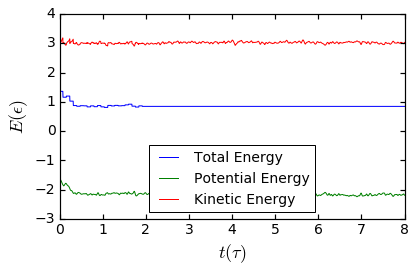

In [15]:
[r, p] = simulate(N,T,a,r_cut,noCutoff,dt,nsteps,energyPlot=True)

<h3>Sim 2: Canonical Ensemble</h3>

A simulation of a canonical ensemble. The number of particles, the volume, and the temperature are kept constant.

In [16]:
T = 1.5           # Temperature. T = (temperature in Kelvin) / 119.8 
nsteps = 1000   # Number of timesteps

#System size
N = 864         # Number of particles
a = 2           # Unit cell size

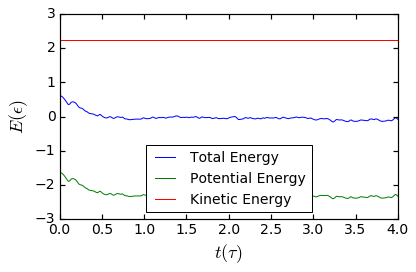

In [17]:
[r, p] = simulate(N,T,a,r_cut,noCutoff,dt,nsteps,energyPlot=True,constantT=True)

<h3>Sim 3: The correlation function</h3>

Determine the correlation function of a specific system.

In [18]:
T = 1           # Temperature. T = (temperature in Kelvin) / 119.8 
nsteps = 1000   # Number of timesteps

#System size
N = 2048        # Number of particles
a = 1.43         # Unit cell size

In [19]:
r = simulate(N,T,a,r_cut,noCutoff,dt,nsteps)[0];

In [20]:
nbins = 1600

[Cor_func, Center] = Correlation_function(r,nbins)

#np.save('.\Data\corfunc', Cor_func)
#np.save('.\Data\corfunc', Center)

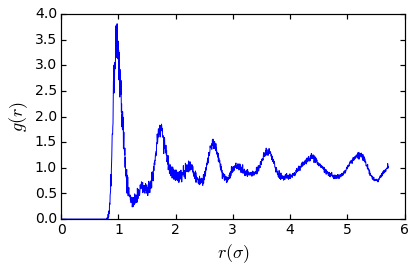

In [21]:
plt.figure()
plt.plot(Center, Cor_func)
plt.xlabel(r'$r (\sigma)$')
plt.ylabel(r'$g(r)$')
#plt.savefig('.\Figures\Cor_func')
plt.show()

<h3>Sim 4: Pressure of a gas</h3>

Using the virial theorem we compute the pressure of the gas.

In [22]:
density_array = [np.linspace(0.7, 1.3, 5), np.linspace(0.2, 1.2, 5), np.linspace(0.2, 0.9, 5)]
T_array = np.array([1, 1.35, 2.7])

neq = 500       # equilibrium point
nsteps = 2500   # Number of timesteps

#System size
N = 864         # Number of particles

In [23]:
[meanPressure, std] = compPressure(N,T_array,density_array,r_cut,noCutoff,dt,nsteps,neq)

#Saving data
#np.save('.\Data\meanPressure', meanPressure)
#np.save('.\Data\stdPressure', std)  

0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 

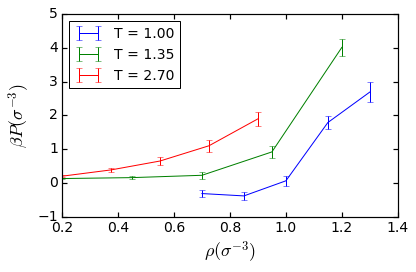

In [24]:
plt.figure()
plt.errorbar(density_array[0],meanPressure[0][:]/T_array[0], yerr=std[0][:])
plt.errorbar(density_array[1],meanPressure[1][:]/T_array[1], yerr=std[1][:])
plt.errorbar(density_array[2],meanPressure[2][:]/T_array[2], yerr=std[2][:])
plt.legend(['T = %.2f' %(T_array[0]), 'T = %.2f' %(T_array[1]), 'T = %.2f' %(T_array[2])], loc = 2)
plt.xlabel(r'$\rho (\sigma^{-3})$')
plt.ylabel(r'$\beta P (\sigma^{-3})$')
plt.savefig('.\Figures\Pressure_vs_Density_14.png')
plt.show()

Plotting some saved data

In [25]:
meanPressure = np.load('.\Data\meanPressure_14.npy')
std = np.load('.\Data\stdPressure_14.npy') 
density_array = [np.linspace(0.8, 1.2, 20), np.linspace(0.1, 1.2, 20), np.linspace(0.1, 1.0, 20)]
T_array = np.array([1, 1.35, 2.7])

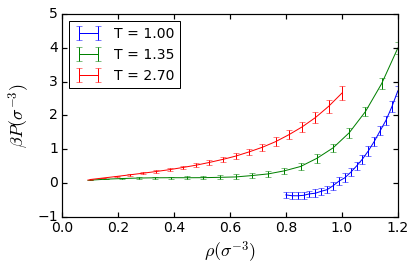

In [26]:
plt.figure()
plt.errorbar(density_array[0],meanPressure[0][:]/T_array[0], yerr=std[0][:])
plt.errorbar(density_array[1],meanPressure[1][:]/T_array[1], yerr=std[1][:])
plt.errorbar(density_array[2],meanPressure[2][:]/T_array[2], yerr=std[2][:])
plt.legend(['T = %.2f' %(T_array[0]), 'T = %.2f' %(T_array[1]), 'T = %.2f' %(T_array[2])], loc = 2)
plt.xlabel(r'$\rho (\sigma^{-3})$')
plt.ylabel(r'$\beta P (\sigma^{-3})$')
#plt.savefig('.\Figures\Pressure_vs_Density_14.png')
plt.show()

<h3>Sim 5: Heat capacity NVT and NVE</h3>

Computing the heat capacity for a microcanonical system.

In [27]:
T_vector = np.linspace(1.5,5,10)   # Temperature. T = (temperature in Kelvin) / 119.8 
a_vector = np.array([1.43, 2.0, 2.8])  # Unit cell size
density_vector = 4/(a_vector**3)
N = 864                             # Number of particles
nsteps = 10000
nequi = 1000

In [28]:
[Cv, Cv_std] = Heat_capacity_NVE(N,T_vector,a_vector,r_cut,noCutoff,dt,nsteps,nequi)

0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 

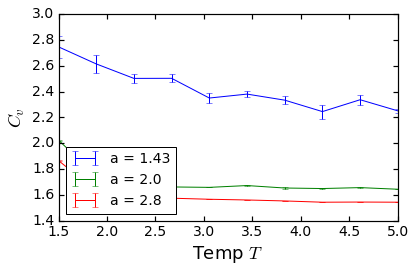

In [29]:
#Saving data
#np.save('.\Data\Cv, Cv) 
#np.save('.\Data\Cv_std', Cv_std)

plt.figure()
plt.errorbar(T_vector,Cv[0,:], yerr=Cv_std[0,:])
plt.errorbar(T_vector,Cv[1,:], yerr=Cv_std[1,:])
plt.errorbar(T_vector,Cv[2,:], yerr=Cv_std[2,:])
plt.legend(['a = 1.43', 'a = 2.0','a = 2.8'], loc = 3)
plt.xlabel(r'Temp $T$')
plt.ylabel(r'$C_v$')
#plt.savefig('.\Figures\Heat_cap.png')
plt.show()

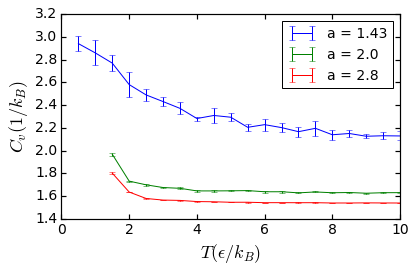

In [30]:
Cv_10 = np.load('.\Data\Cv_block_10.npy')
std_10 = np.load('.\Data\Cv_block_std_10.npy')

T_vector10 = np.linspace(0.5,10,20)

plt.figure()
plt.errorbar(T_vector10[:],Cv_10[0,:], yerr=std_10[0,:])
plt.errorbar(T_vector10[2:],Cv_10[1,2:], yerr=std_10[1,2:])
plt.errorbar(T_vector10[2:],Cv_10[2,2:], yerr=std_10[2,2:])
plt.legend(['a = 1.43', 'a = 2.0','a = 2.8'], loc = 1)
plt.xlabel(r'$T (\epsilon /k_{B})$')
plt.ylabel(r'$C_v (1/k_{B})$')
#plt.savefig('.\Figures\Heat_cap_10.png')
plt.show()

The same but for a microcanonical system.

In [31]:
T_vector = np.linspace(1,10,10)   # Temperature. T = (temperature in Kelvin) / 119.8 
a_vector = np.array([1.43, 2.0, 2.8])  # Unit cell size
density_vector = 4/(a_vector**3)

N = 864                            # Number of particles
nsteps = 10000
neq = 1000

In [32]:
[CvT, Cv_stdT] = Heat_capacity_NVT(N,T_vector,a_vector,r_cut,noCutoff,dt,nsteps,neq)

0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 

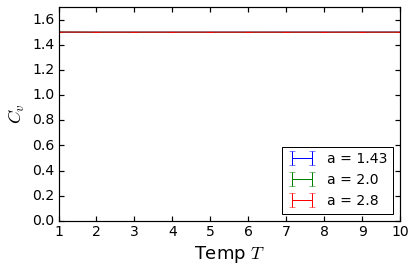

In [34]:
#Saving data
#np.save('.\Data\CvT', CvT) 
#np.save('.\Data\CvT_std', Cv_stdT)

plt.figure()
plt.errorbar(T_vector,CvT[0,:], yerr=Cv_stdT[0,:])
plt.errorbar(T_vector,CvT[1,:], yerr=Cv_stdT[1,:])
plt.errorbar(T_vector,CvT[2,:], yerr=Cv_stdT[2,:])
plt.ylim([0,1.7])
plt.legend(['a = 1.43','a = 2.0', 'a = 2.8'], loc = 4)
plt.xlabel(r'Temp $T$')
plt.ylabel(r'$C_v$')
#plt.savefig('.\Figures\Heat_capT.png')
plt.show()

<h3>Sim 6: Mean square displacement</h3>

In [40]:
T = 2.5           # Temperature. T = (temperature in Kelvin) / 119.8 
a = 2             # Unit cell size
steps = [20, 50]  # [stepsize, number of steps]
N = 864           # Number of particles
neq = 1000        # Equilibrium time

In [41]:
[r_mean, time] = sqrdisplacement(N,T,a,r_cut,noCutoff,dt,steps,neq)
time = time*dt

In [42]:
fitcoeff, fitcov = np.polyfit(time,r_mean,1,full=False,cov=True)

y = fitcoeff[0]*time + fitcoeff[1]

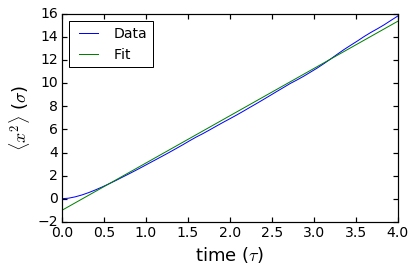

In [43]:
#np.save('.\Data\meansqr_gas_smallt_N=864',r_mean)
#np.save('.\Data\meansqr_gas_smallt_N=864',time)
#np.save('.\Data\meansqr_gas_smallt_N=864',np.array([fitcoeff[0], fitcov[0,0]]))

plt.figure()
plt.plot(time,r_mean)
plt.plot(time,y)
plt.xlabel(r'time ($\tau$)')
plt.ylabel(r'$\langle x^2 \rangle $ ($\sigma$)')
plt.legend(['Data', 'Fit'],loc=2)
#plt.savefig('.\Figures\meansqr_N=864.png')
plt.show()